Dataset Shape: (339, 16)
Duplicate Rows: 53
Null Values:
 GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64


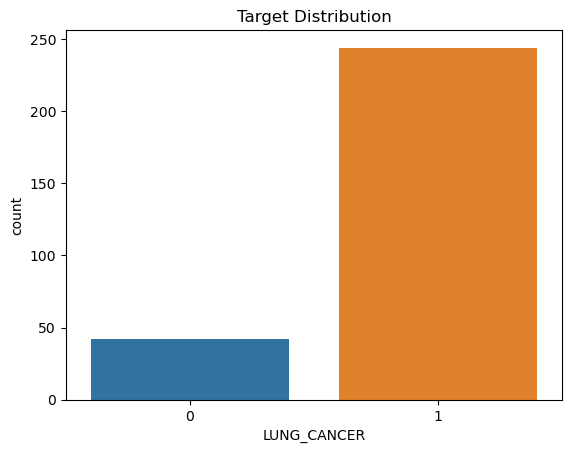

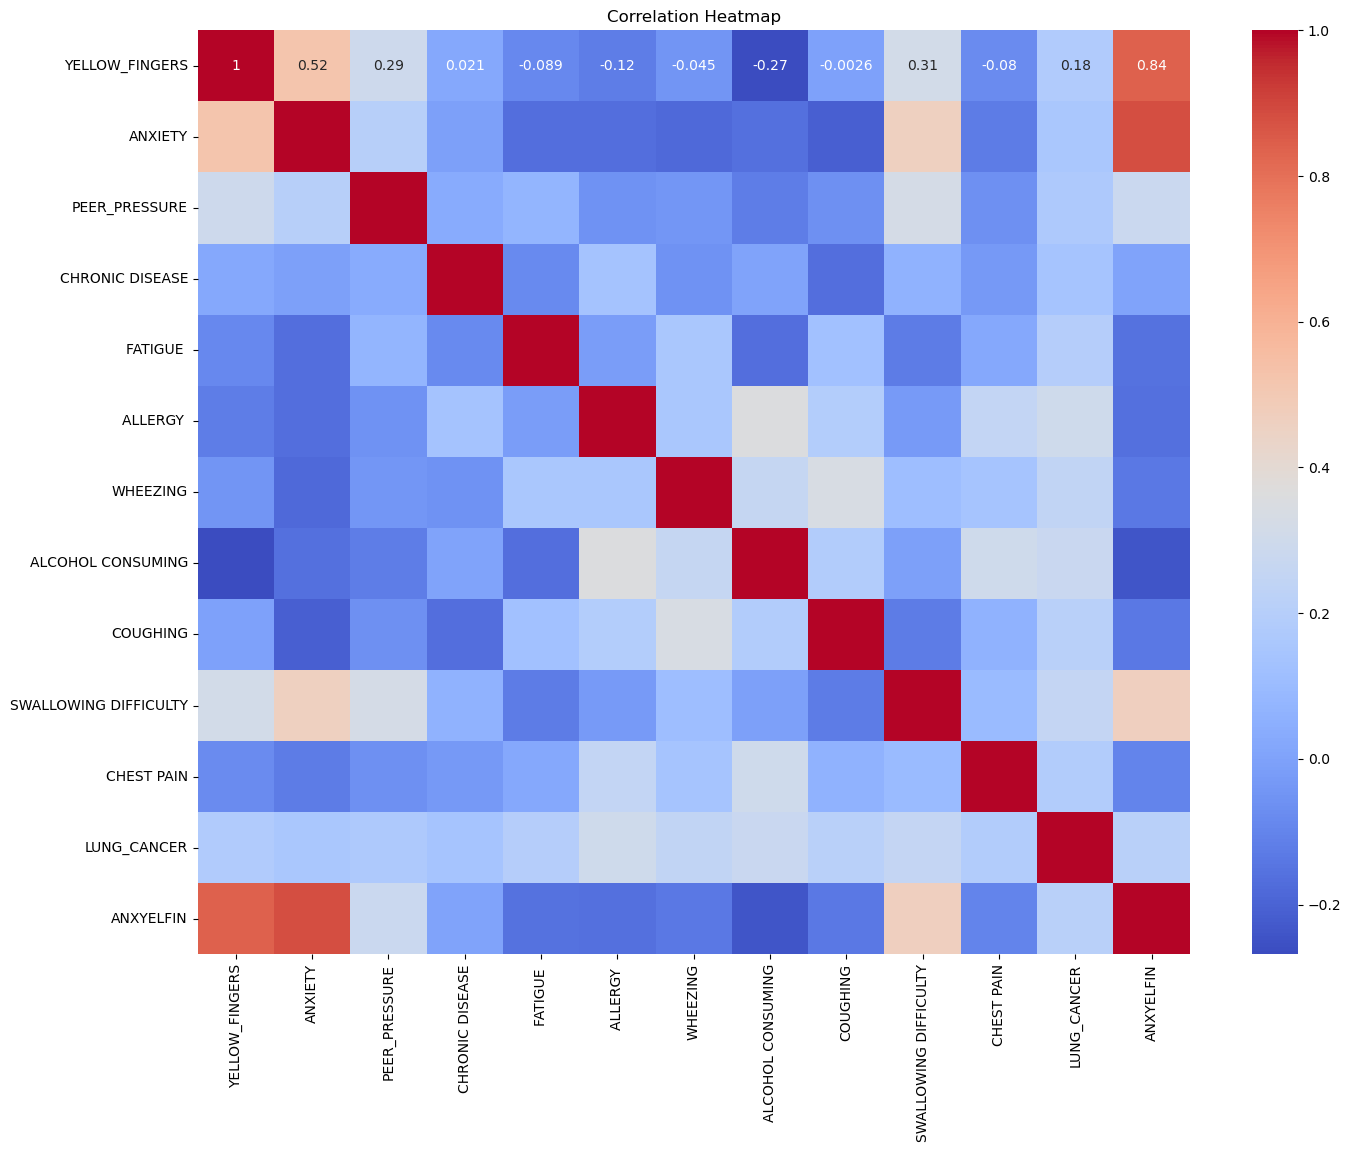

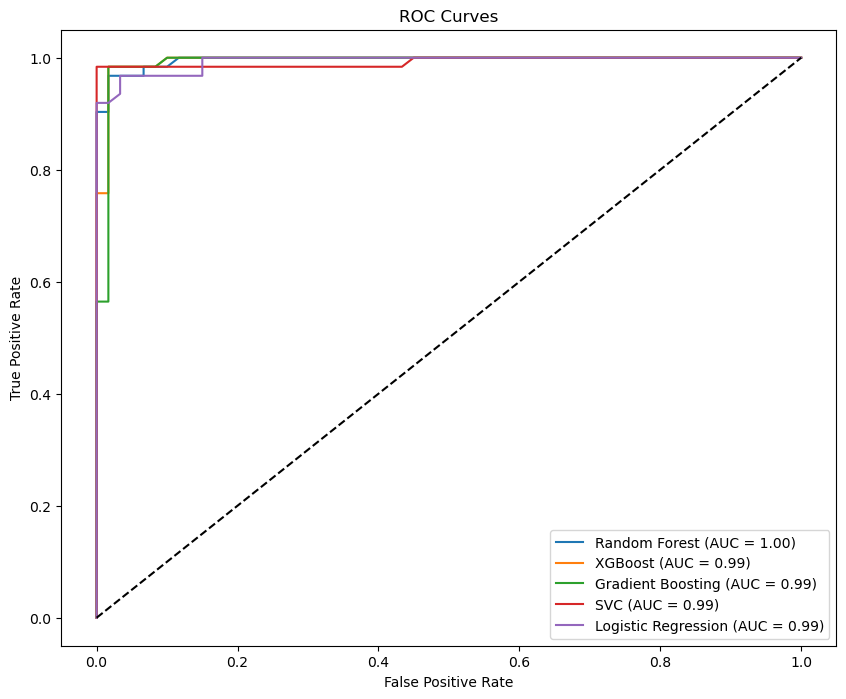

Random Forest: AUC = 0.9961
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        60
           1       0.97      0.97      0.97        62

    accuracy                           0.97       122
   macro avg       0.97      0.97      0.97       122
weighted avg       0.97      0.97      0.97       122

XGBoost: AUC = 0.9948
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        60
           1       0.97      0.97      0.97        62

    accuracy                           0.97       122
   macro avg       0.97      0.97      0.97       122
weighted avg       0.97      0.97      0.97       122

Gradient Boosting: AUC = 0.9915
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        60
           1       0.97      0.97      0.97        62

    accuracy                

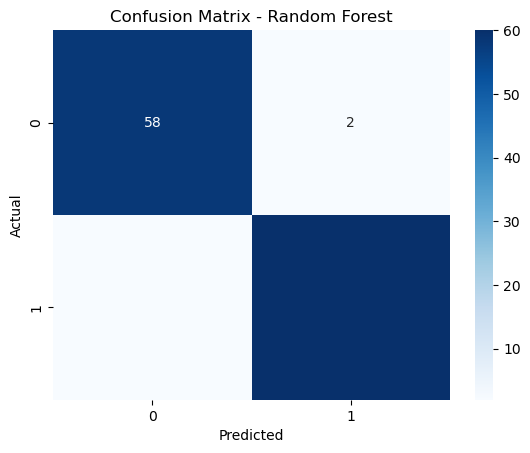

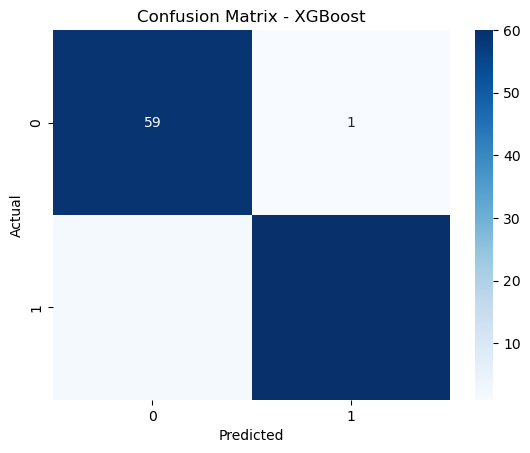

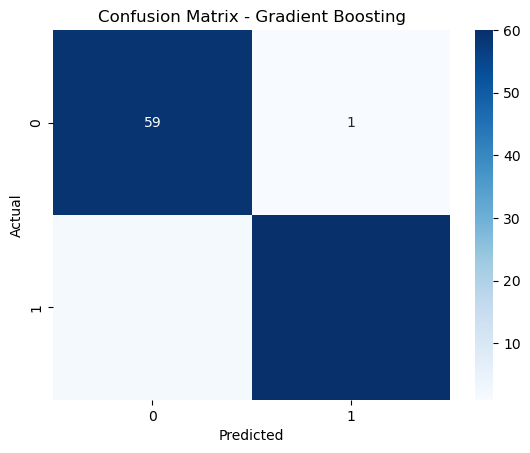

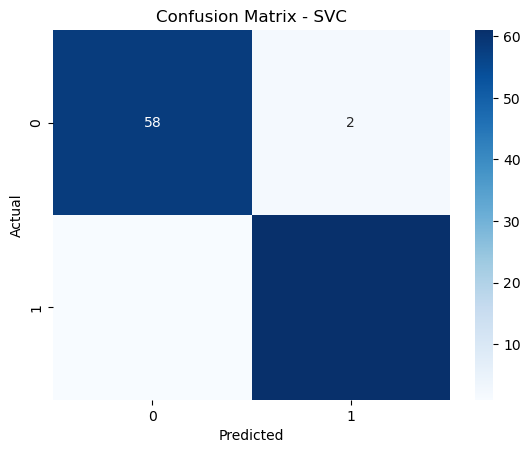

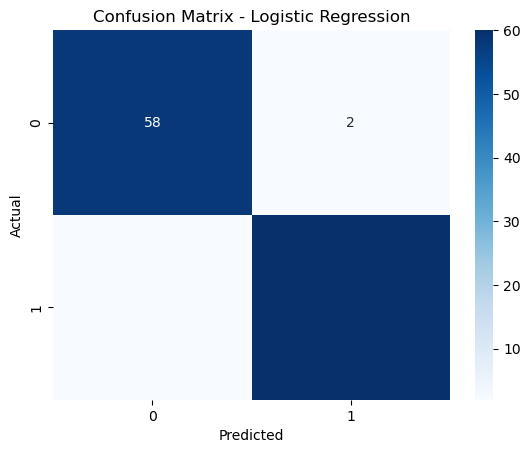

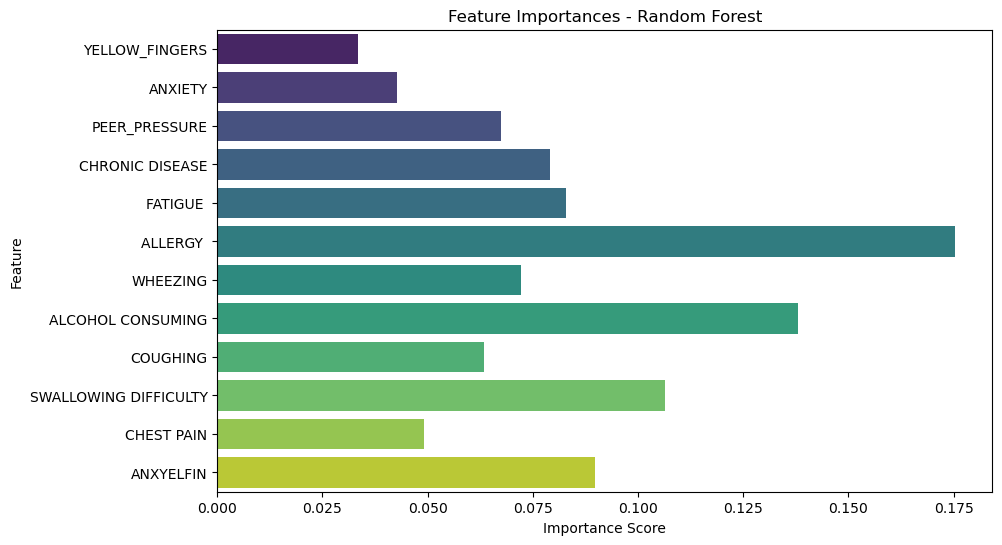

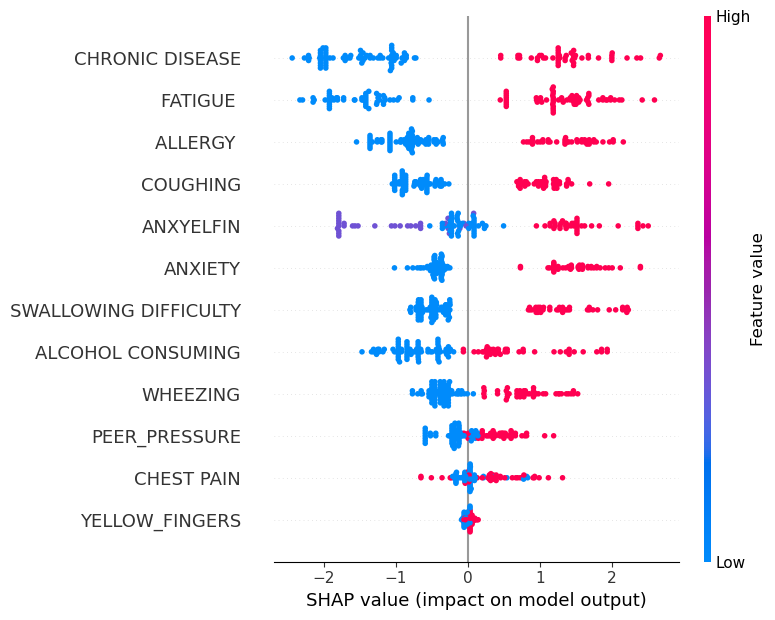

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings("ignore")

# Load Data
df = pd.read_csv(r"D:\\PT\\Research paper\\survey lung cancer.csv")

# Data Overview
print("Dataset Shape:", df.shape)
print("Duplicate Rows:", df.duplicated().sum())
df = df.drop_duplicates()

# Check for Null Values
print("Null Values:\n", df.isnull().sum())

# Encode Categorical Variables
encoder = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = encoder.fit_transform(df[col])

# Distribution of Target Variable
sns.countplot(x='LUNG_CANCER', data=df)
plt.title('Target Distribution')
plt.show()

# Feature Engineering
# Add Interaction Feature
df['ANXYELFIN'] = df['ANXIETY'] * df['YELLOW_FINGERS']

# Drop Less Relevant Features
df_new = df.drop(columns=['GENDER', 'AGE', 'SMOKING', 'SHORTNESS OF BREATH'])

# Correlation Analysis
plt.figure(figsize=(16, 12))
sns.heatmap(df_new.corr(), cmap="coolwarm", annot=True)
plt.title("Correlation Heatmap")
plt.show()

# Prepare Data for Modeling
X = df_new.drop('LUNG_CANCER', axis=1)
y = df_new['LUNG_CANCER']

# Handle Class Imbalance
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Define Top 5 Models
models = {
    "Random Forest": RandomForestClassifier(random_state=0),
    "XGBoost": XGBClassifier(random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    "SVC": SVC(probability=True, random_state=0),
    "Logistic Regression": LogisticRegression()
}

# Evaluate Models
results = {}
plt.figure(figsize=(10, 8))
for name, model in models.items():
    # Standardize and Train Model
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model.fit(X_train_scaled, y_train)

    # Predictions and AUC Score
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    results[name] = auc_score

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

# Plotting the ROC Curve
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

# Print Model Performance
for name, auc in results.items():
    print(f"{name}: AUC = {auc:.4f}")
    print("Classification Report:\n", classification_report(y_test, model.predict(X_test_scaled)))

# Confusion Matrices
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Feature Importance for Random Forest
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train_scaled, y_train)
importances = rf_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features, palette='viridis')
plt.title('Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# SHAP Summary Plot for XGBoost
explainer = shap.TreeExplainer(models["XGBoost"])
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test)
